## Helper Functions

In [1]:
def export_test_csv(df,name,sep=","):
    df.to_csv("../test_exports/"+name+".csv",sep=sep)

In [2]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

In [3]:
#Helper function to find a spot in a matrix
def findSpot(matrix,plot):
    maxrows = matrix.shape[0] #amount of rows
    maxcols = matrix.shape[1] #amount of cols
    
    rowc = -1
    for row in matrix:
        rowc = rowc+1
        itemc = -1
        for item in row:
            itemc = itemc + 1
            if (rowc + plot[0] > maxrows) or (itemc + plot[1] > maxcols):
                continue
            if item == 0: #find potential spot
                space = True
                for i in range(rowc,rowc+plot[0]):#find out whether it fits
                    for u in range(itemc,plot[1]):
                        if matrix[i,u] == 1: 
                            space = False
                if space:
                    return((rowc,itemc))
    return False


In [4]:
# Create Subplot, return figure and array of axes
def create_subplot_fig(title = "Unnamed Plot",figsize=(12,8),x=1,y=1,names=["1","2"]):
    
    fig,axes = plt.subplots(nrows=y,ncols=x,figsize=figsize)
    fig = style_fig(fig,title=title)

    if x*y == 1:
        axes = np.array([axes])
    
    if x>1 and y>1:
        axes = axes.flatten()

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')

    # case more than one
    if len(names) == x*y:
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i = i+1                 
    return fig,axes

#Create a gridplot that automatically arranges plots from left to right and horizontally
def create_gridplot(title="Unnamed Plot",figsize=(12,8),gridsize=(6,3),plotsizes=[(3,2),(1,1),(1,2)],direction="h",names=[]):
    
    fig  = create_fig(title=title,figsize=figsize)
    fig=style_fig(fig,title=title)
    
    axes = []
    taken = np.zeros(gridsize)
    
    if direction == "h":
        for plot in plotsizes:
            spot = findSpot(taken,plot)
            if spot:
                for i in range(spot[0],spot[0]+plot[0]):
                    for u in range(spot[1],spot[1]+plot[1]):
                        taken[i,u] = 1
                axes.append(plt.subplot2grid(gridsize, spot, colspan=plot[1], rowspan=plot[0]))
            else: 
                print("no spot found")
    else: 
        print("Vertical Option is not implemented yet")

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')
        
    if len(axes) == len(names):
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i=i+1
    return fig,axes



# Give Figure a styling
def style_fig(fig,title="Unnamed Plot"):
    fig.suptitle(title, x=0.5, y=0.98, color='black',size=15,fontname="Arial")
    fig.tight_layout()
    return fig

# create figure
def create_fig(title = "Unnamed Plot",figsize=(12,8)):
    fig = plt.figure(figsize = figsize)
    fig = style_fig(fig,title)
    return fig

___________________________

# 0. Preparation

### Python Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
from fastparquet import write
import parquet
import contextily as ctx
import seaborn as sns

### Data Read-In

In [7]:
df = pd.read_parquet("../data/df_cleaned_09_08_2021.parquet")
df = df.sample(100000)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 15695380 to 7884153
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Trip ID                     100000 non-null  object        
 1   Taxi ID                     99970 non-null   object        
 2   Trip Start Timestamp        100000 non-null  datetime64[ns]
 3   Trip End Timestamp          100000 non-null  datetime64[ns]
 4   Trip Seconds                100000 non-null  float64       
 5   Trip Miles                  100000 non-null  float64       
 6   Pickup Census Tract         76450 non-null   float64       
 7   Dropoff Census Tract        76450 non-null   float64       
 8   Pickup Community Area       99994 non-null   float64       
 9   Dropoff Community Area      99696 non-null   float64       
 10  Fare                        100000 non-null  float64       
 11  Tips                        100

### Data Preparation and Column Adding 

In [ ]:
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')

df=df.replace("NaN",np.nan)
df=df.replace("nan",np.nan)

df["mph"]=df["Trip Miles"]/(df["Trip Seconds"] / (60*60))
df['Trip_Min']=df['Trip Seconds']/60

We first want to find out how long most taxis in our fleet operate. It seems like the majority of Taxi IDs operates throughout a significant amount of days within our analysis time frame.
We define the size of the fleet as the amount of Taxis that had at least one ride within the last 5 days.

In [115]:
def get_fleet_size(min_date,max_date):
    #the number of unique Taxi IDs that are within the given Time Frame
    return len(df[(df["PU_DATE"]>=min_date) & (df["PU_DATE"]<=max_date)]["Taxi ID"].unique())

In [116]:
days=14

date_range = pd.date_range(start=df.PU_DATE.min(), end=df.DO_DATE.max(),freq="1d")
date_range_df = pd.DataFrame(index=date_range)

date_range_df["min_date"]=date_range.date-pd.Timedelta(days=days)
date_range_df["max_date"]=date_range.date

date_range_df.sample(3)

,min_date,max_date
2017-04-01,2017-03-18,2017-04-01
2017-10-01,2017-09-17,2017-10-01
2017-09-04,2017-08-21,2017-09-04


In [117]:
#df.to_csv("../test_exports/test_fleetsize.csv",sep=";")

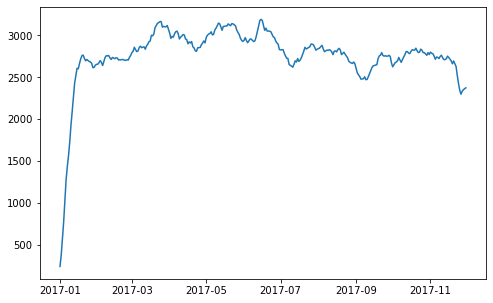

In [118]:
fleet_size = []
for _,row in date_range_df.iterrows():
    maxdate = row["max_date"]
    mindate = row["min_date"]
    fsize = get_fleet_size(mindate,maxdate)
    fleet_size.append({"date":maxdate,
                        "fleet_size":fsize
                       })
fleet_size=pd.DataFrame(fleet_size)

# Plot Fleet Size over the year
fig,ax=plt.subplots(figsize=(8,5))
_= ax.plot(fleet_size.date,fleet_size.fleet_size)

## Include Holidays

For all free days in Chicago, we want to adapt our "isWorkday" feature in order to be more accurate.

In [22]:
illinois_holidays = pd.read_csv("../data/holidays_illinois.csv",sep=";")
illinois_holidays["date"] = pd.to_datetime(illinois_holidays["date"],format = '%d.%m.%Y').dt.date
illinois_holidays["free_day"] = True
illinois_holidays.head(3)

,Holiday,date,free_day
0,New Year's Day,2017-01-01,True
1,Martin Luther King Day,2017-01-18,True
2,Lincoln's Birthday,2017-02-12,True


In [23]:
## TODO: Check whether this really works without any bugs
def adapt_workday(isWorkday,date):
    bol = isWorkday
    if date in illinois_holidays["date"].to_numpy():
        bol = False
    return bol

df["PU_isWorkday"] = df.apply(lambda x: adapt_workday(x["PU_isWorkday"],x["PU_DATE"]),axis=1)
df["DO_isWorkday"] = df.apply(lambda x: adapt_workday(x["DO_isWorkday"],x["DO_DATE"]),axis=1)

## Build different aggregation levels

In [25]:
df_daily = df.groupby("PU_DATE").agg(daily_trips=("PU_DATE","count"),
                                                 DATE=("PU_DATE","min"))
df_daily = pd.merge(df_daily,fleet_size,left_index=True,right_on="date",how="left")
df_hourly = df.groupby(["PU_DATE","PU_HOUR"]).agg(trip_count=("PU_HOUR","count"),
                                                 HOUR=("PU_HOUR","min"),
                                                 DATE=("PU_DATE","min"),
                                                 trip_duration = ("Trip Seconds","median"),
                                                 workday=("PU_isWorkday","min"),
                                                 mph = ("mph","median"))
df_hourly = pd.merge(df_hourly,df_daily,how="left",left_on = "DATE",right_on="DATE")
df_hourly["relative_trips"] = (df_hourly["trip_count"] / df_hourly["daily_trips"])*100
df_hourly.head(3)

,trip_count,HOUR,DATE,trip_duration,workday,mph,daily_trips,date,fleet_size,relative_trips
0,23,1,2017-01-01,790.0,False,10.083538,257,2017-01-01,243,8.949416
1,25,2,2017-01-01,720.0,False,10.000000,257,2017-01-01,243,9.727626
2,26,3,2017-01-01,549.0,False,11.066667,257,2017-01-01,243,10.116732


## Descriptive Analysis - Weather

In [122]:
def read_weather_data(path,feature_name):
    fields = ['datetime', 'Chicago']
    weatherdf = pd.read_csv(path, skipinitialspace=True, usecols=fields)
    weatherdf = weatherdf.rename(columns={'Chicago': feature_name})
    weatherdf = weatherdf[(weatherdf["datetime"]>='2017-01-01')& (weatherdf["datetime"]<='2017-12-31')]
    weatherdf = weatherdf.reset_index()
    weatherdf = weatherdf.drop(['index'], axis=1)

temp_chi=read_weather_data('../data/temperature.csv',"Temperature")
hum_chi = read_weather_data('../data/humidity.csv',"Humidity")
wind_chi = read_weather_data('../data/wind_speed.csv',"Wind Speed")
des_chi =  read_weather_data('../data/weather_description.csv',"Wind Speed")

FileNotFoundError: [Errno 2] No such file or directory: '..data/temperature.csv'

In [146]:
weather_hourly = temp_chi.merge(hum_chi, how='left', on='datetime')
weather_hourly = weather_hourly.merge(wind_chi, how='left', on='datetime')
weather_hourly = weather_hourly.merge(des_chi, how='left', on='datetime')
weather_hourly.head()
#https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv

,datetime,Temperature,Humidity,Wind_Speed,Weather_Description
0,2017-01-01 00:00:00,274.06,100.0,4.0,overcast clouds
1,2017-01-01 01:00:00,272.94,50.0,4.0,scattered clouds
2,2017-01-01 02:00:00,272.14,100.0,3.0,sky is clear
3,2017-01-01 03:00:00,270.97,63.0,3.0,sky is clear
4,2017-01-01 04:00:00,270.14,73.0,1.0,sky is clear


In [148]:
def weatherday(dft, attribute):
    dateRange_gi = pd.DataFrame({'datetime' : pd.date_range(start='01/01/2017 00:00:00', end='11/30/2017 00:00:00', freq='H')}) 
    Data = {'DATE': dateRange_gi['datetime'],
        attribute: dft[attribute]
       } 
    dft = pd.DataFrame(Data,columns=['DATE',attribute])
    dft['startdtind'] = dft['DATE'].dt.floor('d')
    dft = dft.groupby('startdtind')[attribute].mean()
    #df_day = pd.Series(df['DATE'].resample('1D').mean())
    return dft

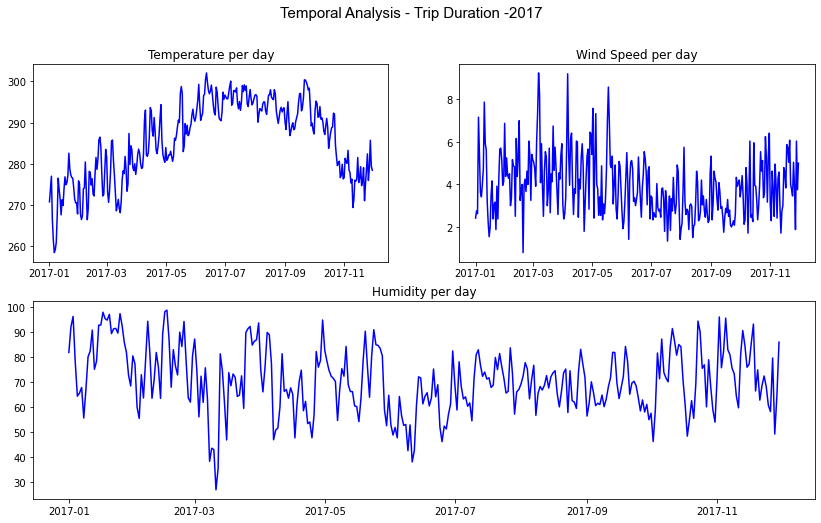

In [149]:
df_day_temp = weatherday(weather_hourly, 'Temperature')
df_day_wind = weatherday(weather_hourly, 'Wind_Speed')
df_day_hum = weatherday(weather_hourly, 'Humidity')

fig,ax=create_gridplot(title="Temporal Analysis - Trip Duration -2017",figsize=(14,8),gridsize=(2,2),plotsizes=[(1,1),(1,1),(1,2)],names=['Temperature per day','Wind Speed per day','Humidity per day'])
ax[0].plot(df_day_temp)
ax[1].plot(df_day_wind)
ax[2].plot(df_day_hum)

## Descriptive Analysis - Temporal (not final)

In [75]:
df["PU_WEEK"] = np.ceil(df["PU_DATE"].dt.dayofyear/7).astype(int)
df_weekly = df.groupby("PU_WEEK").agg(count=("Trip ID","count"))
                                      
df_monthly = df.groupby("PU_MONTH").agg(PU_MONTH_NAME=("PU_MONTH_NAME","min"),
                                        count=("Trip ID","count"),
                                        fare_avg=("Fare","mean"),
                                        tips_avg=("Tips","mean"),
                                        tolls_avg=("Tolls","mean"),
                                        extras_avg=("Extras","mean")
                                       )

df_weekday = df.groupby("PU_WEEKDAY").agg(WEEKDAY_NAME=("PU_WEEKDAY_NAME","min"),
                                         count=("Trip ID","count"))


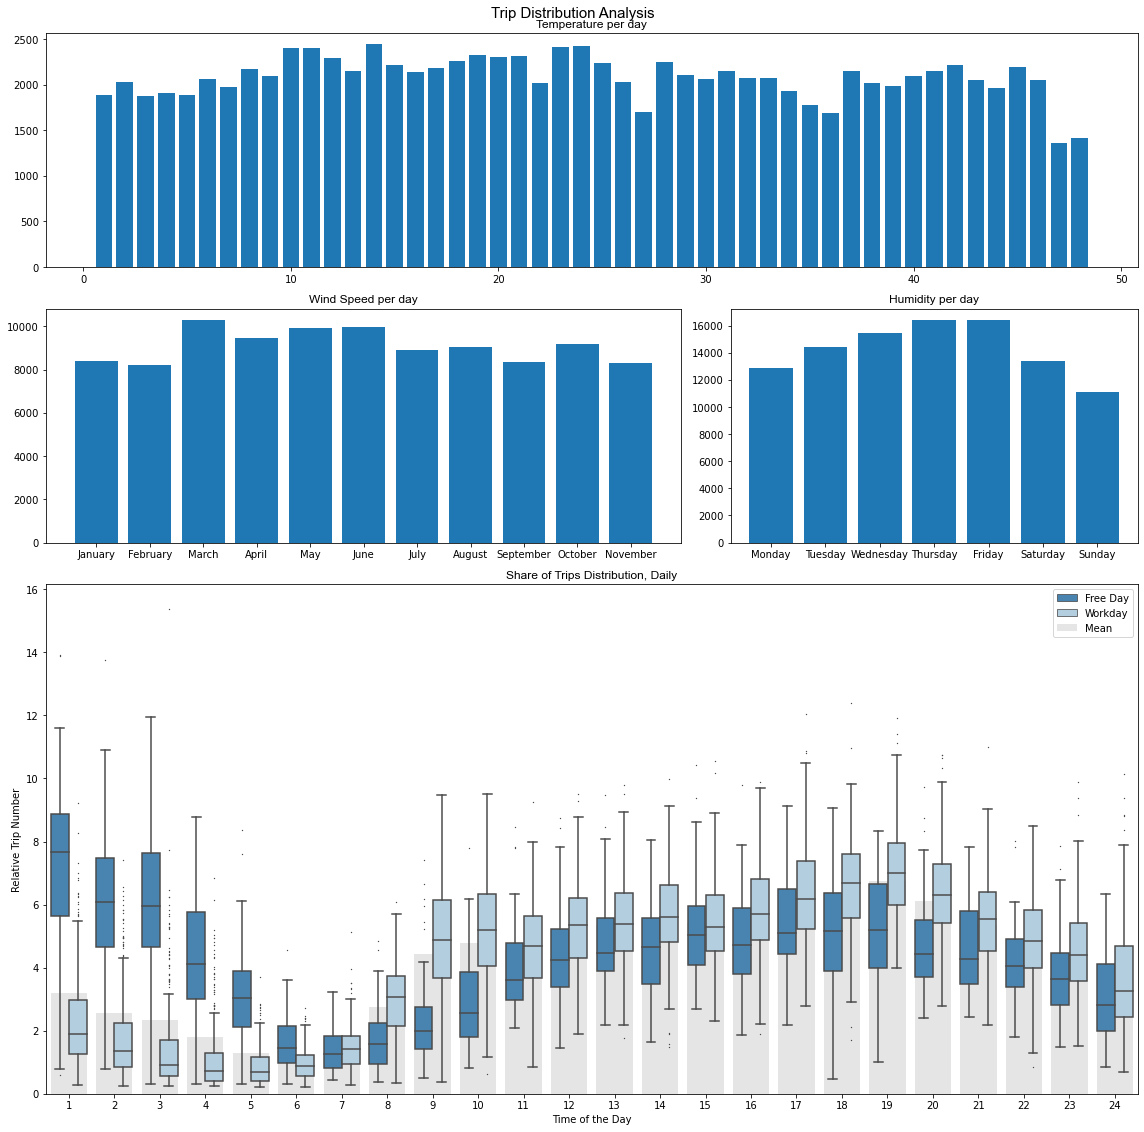

In [92]:
fig,ax=create_gridplot(title="Trip Distribution Analysis",figsize=(18,18),gridsize=(4,5),plotsizes=[(1,5),(1,3),(1,2),(2,5)],names=['Temperature per day','Wind Speed per day','Humidity per day',"Share of Trips Distribution, Daily"])


ax[0].bar(df_weekly.index,df_weekly["count"])
ax[1].bar(df_monthly["PU_MONTH_NAME"],df_monthly["count"])
ax[2].bar(x=df_weekday["WEEKDAY_NAME"],height=df_weekday["count"])


color_palette = "Blues_r"
boxplot = sns.boxplot(ax = ax[3],
                 data=df_hourly, 
                 x="HOUR", 
                 y="relative_trips", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("relative_trips","mean"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax[3],
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax[3].get_legend_handles_labels()
ax[3].legend(handles, ["Free Day", "Workday","Mean"], loc="best")

fig.tight_layout()
_=ax[3].set_ylabel('Relative Trip Number')
_=ax[3].set_xlabel('Time of the Day')

### Analysis of Trip Number

### Analysis of MPH

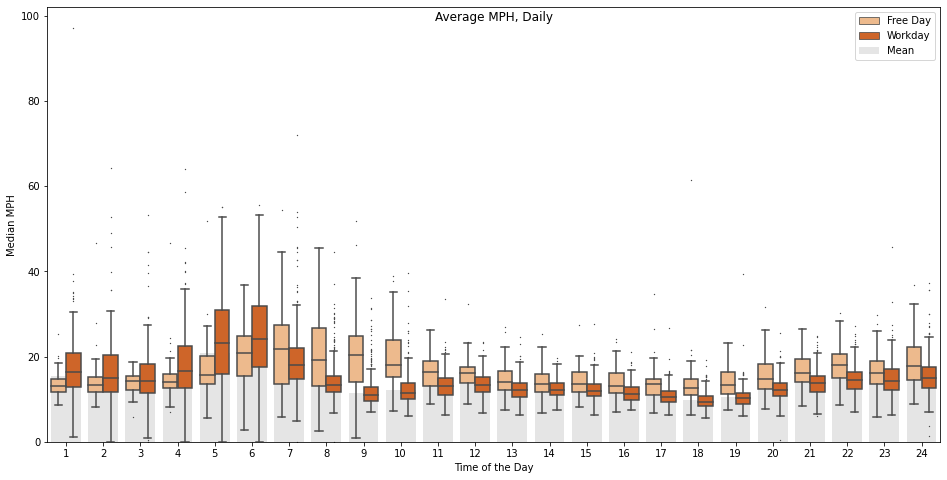

In [169]:
fig,ax = plt.subplots(1, 1, figsize=(16, 8))

color_palette = "Oranges"
boxplot = sns.boxplot(ax = ax,
                 data=df_hourly, 
                 x="HOUR", 
                 y="mph", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("mph","median"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax,
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Free Day", "Workday","Mean"], loc="best")


_=ax.set_title("Average MPH, Daily",y=1.0, pad=-14)
_=ax.set_ylabel('Median MPH')
_=ax.set_xlabel('Time of the Day')

In [78]:
df_monthly.copy()[["fare_avg","tips_avg","tolls_avg","extras_avg"]]

,fare_avg,tips_avg,tolls_avg,extras_avg
PU_MONTH,,,,
1,12.834832,1.409338,0.001698,0.828077
2,12.962800,1.478532,0.000000,0.837227
3,13.250291,1.516725,0.000702,0.891606
4,13.571654,1.588000,0.000934,0.896708
5,14.433935,1.751612,0.002077,1.008135
6,14.335989,1.725636,0.001695,1.021340
7,13.337138,1.472158,0.001431,1.032939
8,13.971979,1.591423,0.008672,1.029945
9,14.341733,1.699827,0.009618,1.018778


<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='month'>

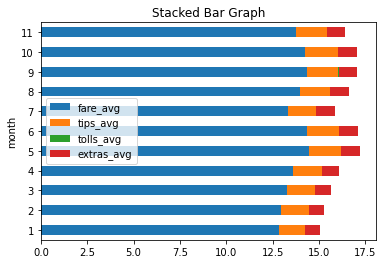

In [90]:
df_monthly_payment = df_monthly.copy()[["fare_avg","tips_avg","tolls_avg","extras_avg"]]
df_monthly_payment["month"] = df_monthly_payment.index

fig,ax=plt.subplots()
df_monthly_payment.plot(
    x = "month",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    ax=ax)

## Trip Duration along 1 hour Buckets and 4 hour buckets


In [190]:
#to be edited
#plottemporal(avgdurationday,avgdurationweek,avgdurationmonth,avgdurationdayoftheweek, 'Temporal Analysis - Starting Time -2017')

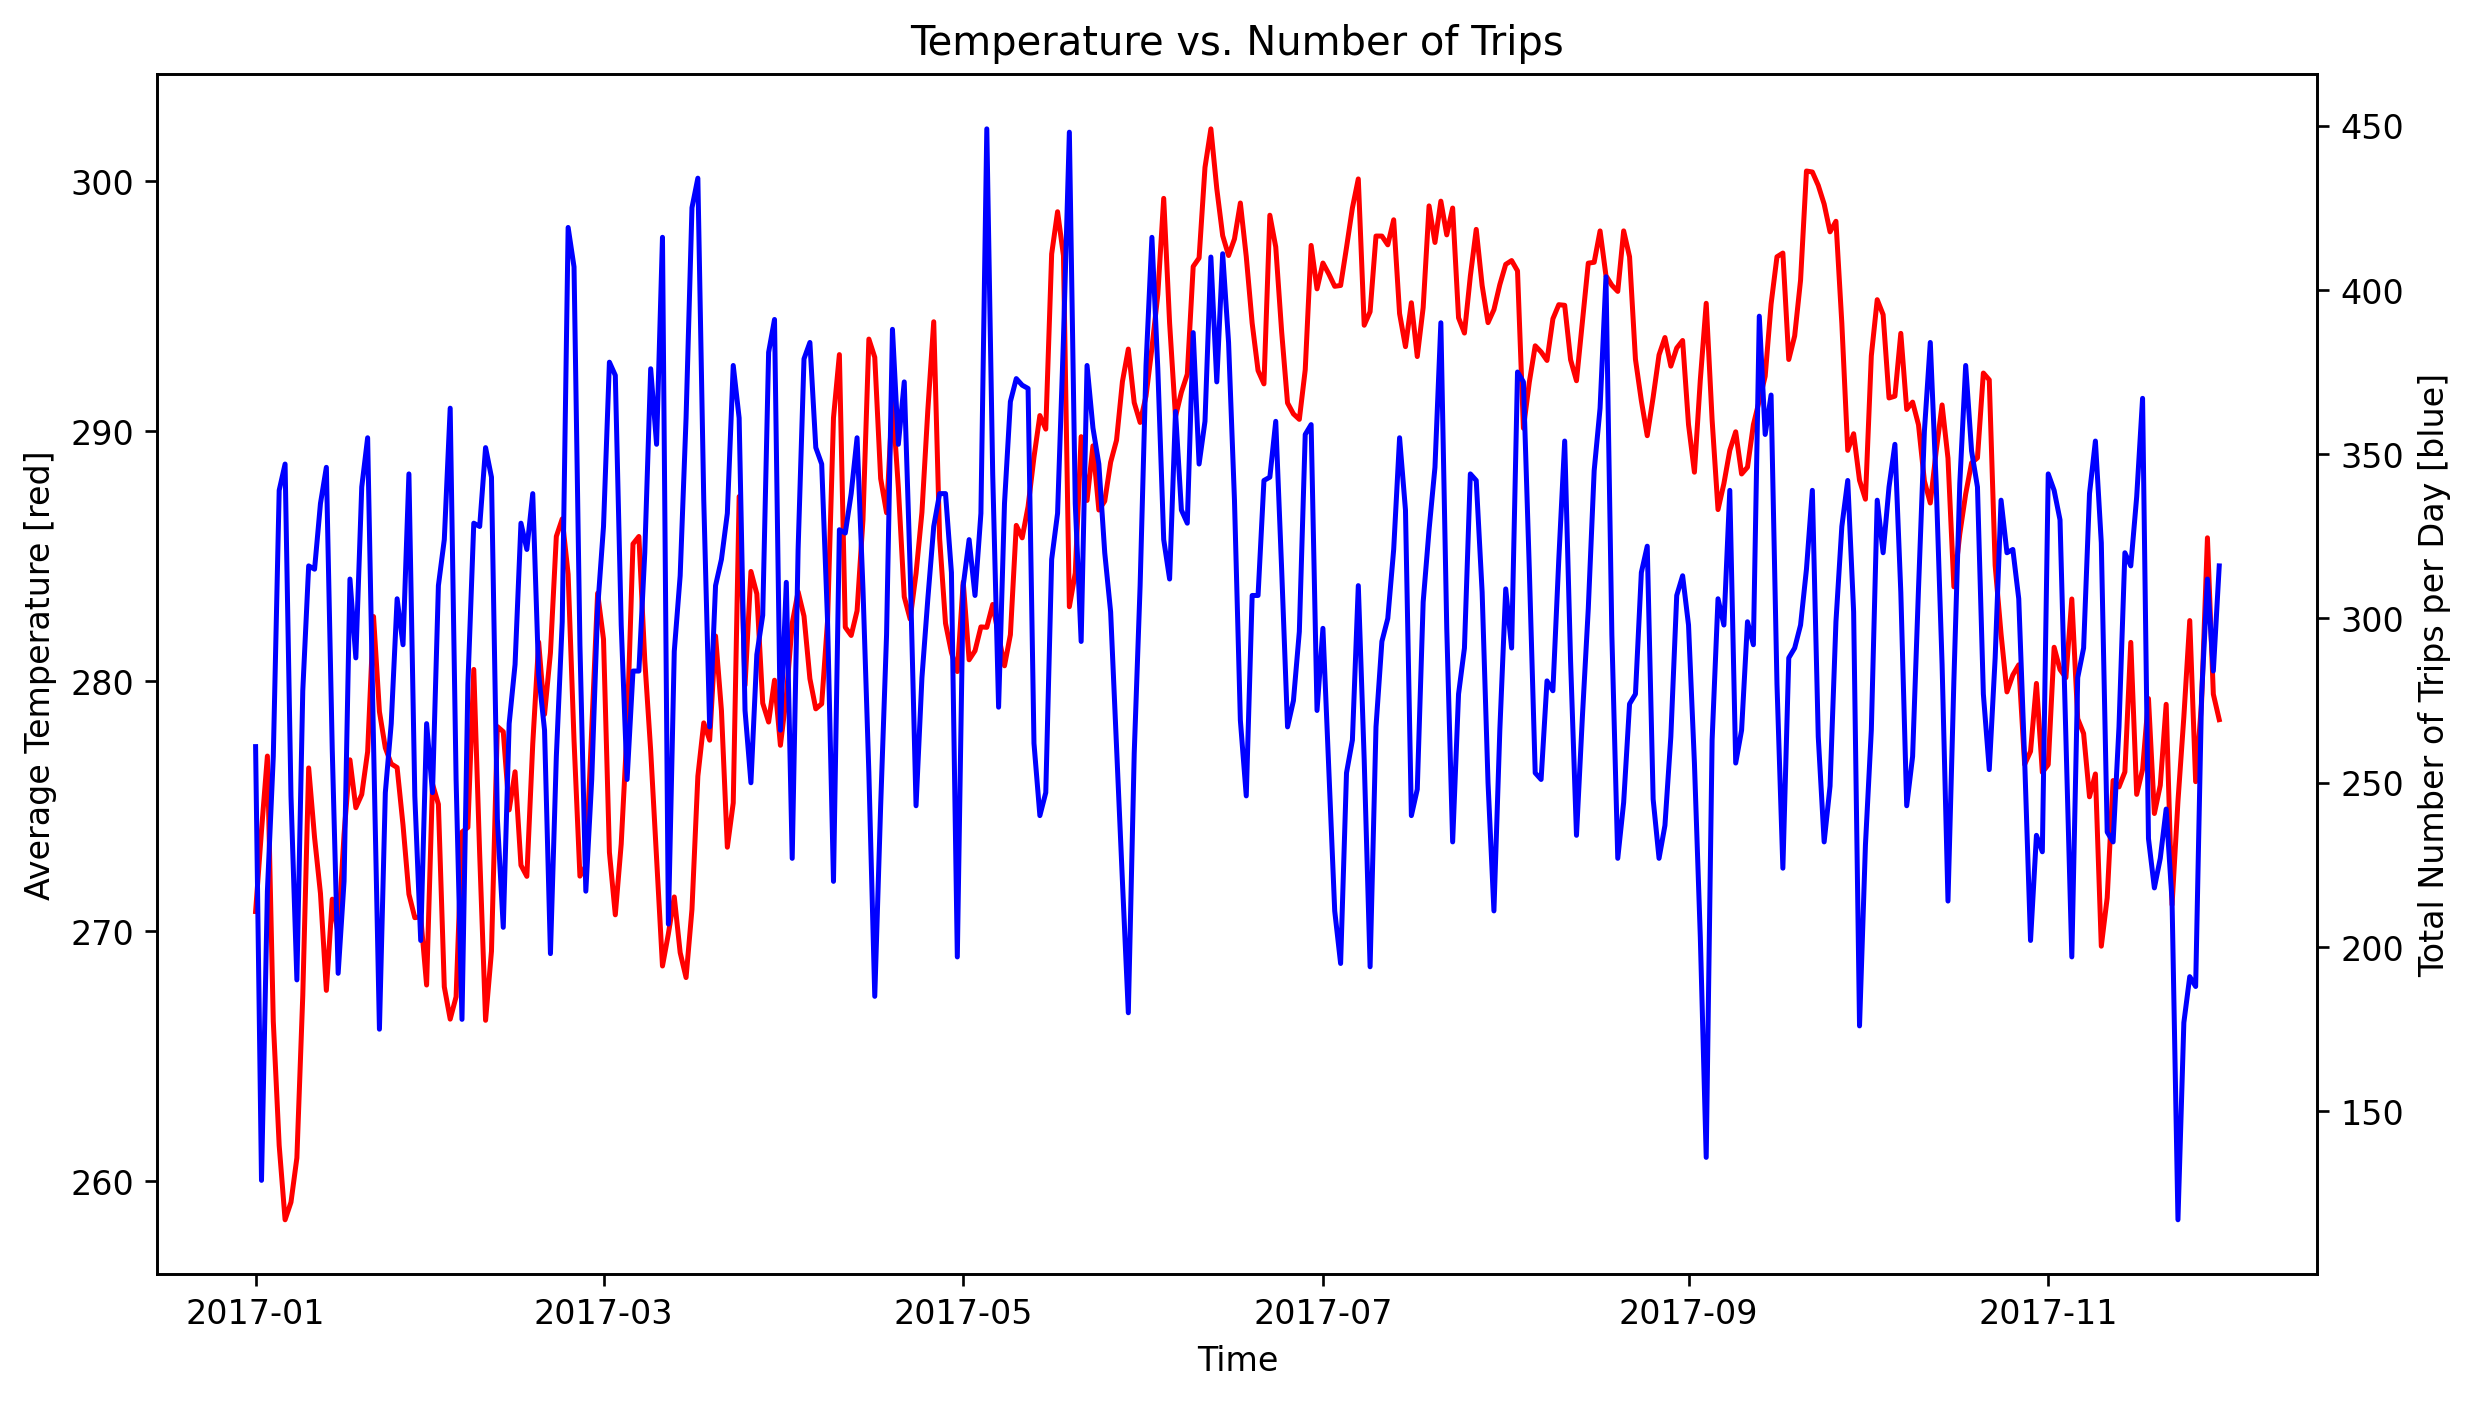

In [180]:
df_trips_per_day = pd.Series(df['Date'].resample('1D').count())

#Plot 
Fig = plt.figure(figsize=(18,10),dpi = 240)
ax1 = Fig.add_axes([0,0,0.5,0.5])
ax1.set_ylabel('Average Temperature [red]', color='Black')
ax1.set_xlabel('Time')
ax1.set_title('Temperature vs. Number of Trips', color='Black')
ax1.plot(df_day_temp, color = 'Red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Total Number of Trips per Day [blue]', color='Black')
ax2.plot(df_trips_per_day, color = 'Blue')

plt.show()

#Save image
#Fig.savefig("Images/TempforStartTime_kassel.png", bbox_inches='tight')


## Descriptive Analysis - Geographic

In [29]:
chicago_census_tracts = gpd.read_file("../data/chicago-census-tracts.geojson")
chicago_census_tracts["geoid10"] = chicago_census_tracts["geoid10"].astype(float)
chicago_census_tracts["centroid"] = chicago_census_tracts.geometry.centroid
chicago_census_tracts.head(3)

chicago_com_areas = gpd.read_file("../data/chicago-community-areas.geojson")
chicago_com_areas["area_num_1"]=chicago_com_areas["area_num_1"].astype(int)
chicago_com_areas["centroid"] = chicago_com_areas["geometry"].centroid
chicago_com_areas.head(3)

<ipython-input-29-e58f59d8f8af>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago_census_tracts["centroid"] = chicago_census_tracts.geometry.centroid
<ipython-input-29-e58f59d8f8af>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago_com_areas["centroid"] = chicago_com_areas["geometry"].centroid


,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry,centroid
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",POINT (-87.61868 41.83512)
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",POINT (-87.60322 41.82375)
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",POINT (-87.63242 41.80909)


### Analysis of Record Quality
In order to explore the geospatial component of our dataset, we need to first clean out all data points that have unsufficient geographic information. We want our data to have Pickup and Dropoff Location Data on either Community Area or Census Tract Level. We eliminate all data points that do not fulfil this. We then want to get a feeling about what Level our Data is on.

In [30]:
df_geo = df.copy()[(~df["Pickup Community Area"].isnull()&~df["Dropoff Community Area"].isnull())|
           (~df["Pickup Census Tract"].isnull()&~df["Dropoff Census Tract"].isnull())]
left=np.round(len(df_geo.index)/len(df.index)*100,2)
print(len(df_geo.index),"Records from",len(df.index),"remained after geo-cleaning.","("+str(left)+"%)")
df_geo.head(3)

100000 Records from 100000 remained after geo-cleaning. (100.0%)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,PU_Centroid,DO_Centroid,PU_isWorkday,DO_isWorkday,mph
2698203,995c96e5458e9b0e98ad5d55be7c9acaed025ffd,beb0579501b2745e10d12af72f99864d506abb7c5de1eb...,2017-02-11 15:30:00,2017-02-11 15:30:00,377.0,1.1,1.703184e+10,1.703108e+10,32.0,8.0,...,6,2017-02-11,2,5,16,POINT (-87.63275 41.88099),POINT (-87.61887 41.89092),True,True,10.503979
1592260,734ea4b00584e56654729e246ceb6a232a8627a6,57f6651b7b2eb4a909751a93769dadbe2d837ed6ceaa77...,2017-01-26 07:45:00,2017-01-26 07:45:00,789.0,2.0,1.703128e+10,1.703108e+10,28.0,8.0,...,4,2017-01-26,1,3,8,POINT (-87.64265 41.87926),POINT (-87.62076 41.89833),True,True,9.125475
1959361,f085d6a0140d10e24273d15f56b88a585d0fa65a,6eb285e549ebd23a688f5fe2145d88dba65e200024e421...,2017-01-31 19:15:00,2017-01-31 19:30:00,821.0,2.0,1.703108e+10,1.703184e+10,8.0,32.0,...,5,2017-01-31,1,1,20,POINT (-87.61971 41.89503),POINT (-87.63141 41.87102),True,True,8.769793


In [31]:
import math
def get_accuracy(pu_com_area,do_com_area,pu_census_tr,do_census_tr):
    acc = np.nan
    if not math.isnan(pu_com_area) and not math.isnan(do_com_area):
        acc = "com"
    if not math.isnan(pu_census_tr) and not math.isnan(do_census_tr):
        acc="cens"
    return acc

df_geo["geo_accuracy"] = df_geo.apply(lambda x: get_accuracy(x["Pickup Community Area"],x["Dropoff Community Area"],x["Pickup Census Tract"],x["Dropoff Census Tract"]),axis=1)

if len(df_geo[df_geo["geo_accuracy"].isnull()]) > 0:
       df_geo[df_geo["geo_accuracy"].isnull()]
else:
    print("everything went as planned.")
    df_geo.head(5)

everything went as planned.


In [32]:
df_accuracy = df_geo.copy()
df_accuracy["cens_tract"]=df_accuracy["geo_accuracy"] == "cens"
df_accuracy["cens_tract"] = df_accuracy["cens_tract"].astype(int)
df_accuracy["com_area"]=df_accuracy["geo_accuracy"] == "com"
df_accuracy["com_area"] = df_accuracy["com_area"].astype(int)
df_accuracy=df_accuracy.groupby("Pickup Community Area").agg(census_tract=("cens_tract","sum"),
                                                          community_area=("com_area","sum"))
df_accuracy.index=df_accuracy.index.astype(int)
df_accuracy_sum = pd.DataFrame(df_accuracy.sum(),columns=["sum"])

df_accuracy = pd.merge(df_accuracy,chicago_com_areas,left_index=True,right_on="area_num_1",how="left")
df_accuracy = gpd.GeoDataFrame(df_accuracy,geometry="geometry")
df_accuracy["census_tract_percent"] = df_accuracy["census_tract"] / (df_accuracy["census_tract"]+df_accuracy["community_area"])

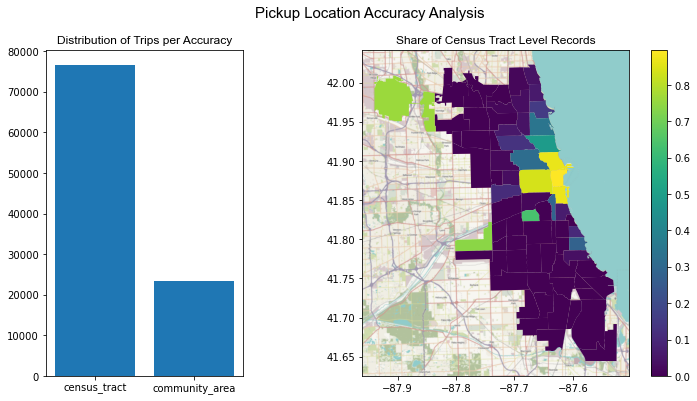

In [33]:
fig,axes=create_gridplot(title = "Pickup Location Accuracy Analysis",figsize=(12,6),gridsize=(1,3),plotsizes=[(1,1),(1,2)],names=["Distribution of Trips per Accuracy","Share of Census Tract Level Records"])
plot = df_accuracy.plot(ax=axes[1],column="census_tract_percent",legend=True)
ctx.add_basemap(ax=axes[1],zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[1],alpha=0) #das macht nur die skalierung richtig

_=axes[0].bar(df_accuracy_sum.index,df_accuracy_sum["sum"])

### Get H3 Resolution in Data

In [159]:
#h3_resolution = h3.h3_get_resolution(df["PU_H3"].iloc[0])
h3_resolution = 8

### Build H3 Grid

Our Goal is to build a h3 Grid that fills out our community areas separately. We do this so that we can then artificially distribute our trips throughout our h3 polygons. This will enable us to make more representative analyses as numbers are distributed throughout either their census tract or their community area, depending on which level of accuracy the record provides.

In [160]:
# Create an empty dataframe to write data into
h3_census_tracts = []
for _,row in chicago_census_tracts.iterrows():
    census_tract=row["geoid10"]
    geometry=row["geometry"][0]
    
    poly_geojson = gpd.GeoSeries([geometry]).__geo_interface__
    # Parse out geometry key from GeoJSON dictionary
    poly_geojson = poly_geojson['features'][0]['geometry'] 

    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)
    

    # Fill the dictionary with H3 Hexagons
    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

    for h3_hex in h3_hexes:
        h3_geo_boundary = shapely.geometry.Polygon(
            h3.h3_to_geo_boundary(h3_hex,geo_json=True))
        h3_centroid = h3.h3_to_geo(h3_hex)
        h3_census_tracts.append({"census_tract":census_tract,
                            "h3_id":h3_hex,
                            "h3_geo_boundary":h3_geo_boundary,
                            "h3_centroid":h3_centroid})
    
h3_census_tracts = pd.DataFrame(h3_census_tracts)

In [161]:
# Create an empty dataframe to write data into
h3_com_areas = []
for _,row in chicago_com_areas.iterrows():
    com_area=row["area_num_1"]
    geometry=row["geometry"][0]
    
    poly_geojson = gpd.GeoSeries([geometry]).__geo_interface__
    # Parse out geometry key from GeoJSON dictionary
    poly_geojson = poly_geojson['features'][0]['geometry'] 

    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)
    

    # Fill the dictionary with H3 Hexagons
    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

    for h3_hex in h3_hexes:
        h3_geo_boundary = shapely.geometry.Polygon(
            h3.h3_to_geo_boundary(h3_hex,geo_json=True))
        h3_centroid = h3.h3_to_geo(h3_hex)
        h3_com_areas.append({"com_area":com_area,
                            "h3_id":h3_hex,
                            "h3_geo_boundary":h3_geo_boundary,
                            "h3_centroid":h3_centroid})
    
h3_com_areas = pd.DataFrame(h3_com_areas)
#export_test_csv(h3_census_tracts,"h3_census_tracts",sep=";")

<AxesSubplot:title={'center':'Community Areas'}>

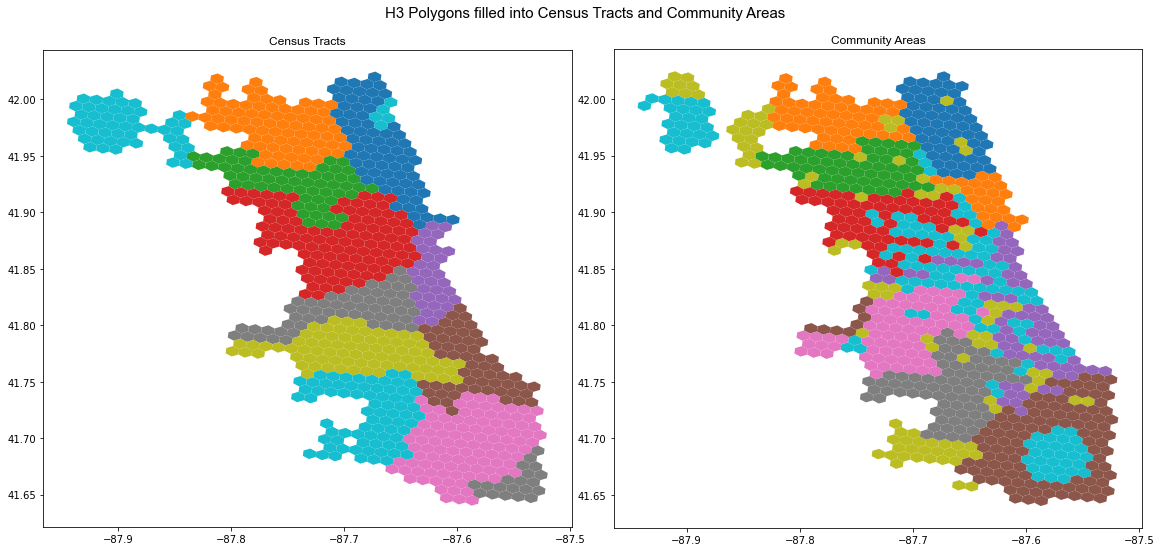

In [162]:
fig,axes = create_subplot_fig(title = "H3 Polygons filled into Census Tracts and Community Areas",figsize=(16,8),x=2,y=1,names=["Census Tracts","Community Areas"])
gpd.GeoDataFrame(h3_com_areas,geometry="h3_geo_boundary").plot(ax=axes[0], categorical=True,column="com_area")
gpd.GeoDataFrame(h3_census_tracts,geometry="h3_geo_boundary").plot(ax=axes[1],categorical=True,column="census_tract")

With Census Tracts and Community Areas filled out with H3 Polygons, we can proceed by assigning each record to the most accurate approximation of Start and End H3 Polygon by selecting a random one from most accurate information.

In [163]:
def get_approx_h3(census_tract,com_area):

    if not math.isnan(census_tract):
        filtered_df = h3_census_tracts[h3_census_tracts["census_tract"]==census_tract]
        if len(filtered_df.index)>1:
            return filtered_df.sample(1)["h3_id"].iloc[0], filtered_df.sample(1)["h3_geo_boundary"].iloc[0]
    
    if not math.isnan(com_area):
        filtered_df = h3_com_areas[h3_com_areas["com_area"]==com_area]
        if len(filtered_df.index)>1:
            return filtered_df.sample(1)["h3_id"].iloc[0], filtered_df.sample(1)["h3_geo_boundary"].iloc[0]
        
    return np.nan, np.nan


def add_approx_h3(df,census_tract_colname,com_area_colname,new_ids_colname,new_polys_colname):

    h3_ids=[]
    h3_polys=[]
    for _,row in df.iterrows():
        
        census_tract = row[census_tract_colname]
        com_area = row[com_area_colname]
        
        h3_id,h3_poly =get_approx_h3(census_tract,com_area)
        h3_ids.append(h3_id)
        h3_polys.append(h3_poly)
        
    if not len(h3_ids) == len(df.index) or not len(h3_polys)==len(df.index):
        print("something went wrong")

    df[new_ids_colname]=h3_ids
    df[new_polys_colname]=h3_polys
    return df

df_geo = add_approx_h3(df_geo,"Pickup Census Tract","Pickup Community Area","PU_H3_acc","PU_H3_acc_poly")
df_geo = add_approx_h3(df_geo,"Dropoff Census Tract","Dropoff Community Area","DO_H3_acc","DO_H3_acc_poly")

To test if our algorithm worked correctly, we plot the trip amount per H3 hexagon of some random community areas and then across our whole dataset.

<AxesSubplot:>

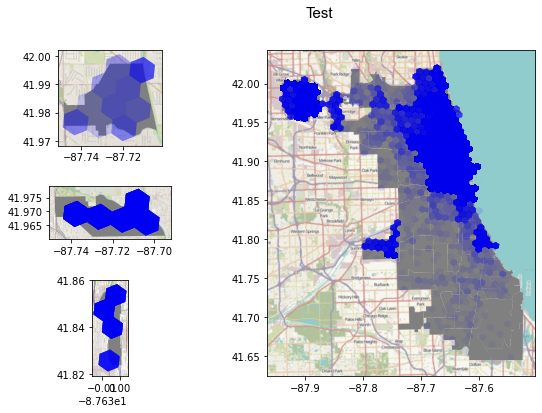

In [207]:
fig,axes=create_gridplot(title="Test",figsize=(10,6),gridsize=(3,4),plotsizes=[(1,1),(3,3),(1,1),(1,1)],direction="h",names=[])

# Plot one Test Community Area
test_comarea = 13.0
test_df = df_geo[df_geo["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[0],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_acc_poly").plot(ax=axes[0],color="blue",alpha=0.09)
ctx.add_basemap(ax=axes[0],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[0],alpha=0)

# Plot all H3s
chicago_com_areas.plot(ax=axes[1],color="grey")
gpd.GeoDataFrame(df_geo,geometry="PU_H3_acc_poly").plot(ax=axes[1],color="blue",alpha=0.06)
ctx.add_basemap(ax=axes[1],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[1],alpha=0)

# Plot one Test Community Area
test_comarea = 14.0
test_df = df_geo[df_geo["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[2],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_acc_poly").plot(ax=axes[2],color="blue",alpha=0.09)
ctx.add_basemap(ax=axes[2],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[2],alpha=0)


# Plot one Test Community Area
test_comarea = 34.0
test_df = df_geo[df_geo["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[3],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_acc_poly").plot(ax=axes[3],color="blue",alpha=0.09)
ctx.add_basemap(ax=axes[3],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[3],alpha=0)


For trajectory visualisation with Kepler, we build an aggregated dataframe that contains the combination of all Pickup to Dropoff Hexagons that exist in our data.

In [172]:
def get_centroid(poly):
    return poly.centroid

df_geo_traj = df_geo.groupby(["PU_H3_acc","DO_H3_acc"]).agg(count=("Trip ID","count"),
                                                            PU_H3=("PU_H3_acc","first"),
                                                            DO_H3=("DO_H3_acc","first"),
                                                           PU_H3_poly=("PU_H3_acc_poly","first"),
                                                           DO_H3_poly=("DO_H3_acc_poly","first"))

df_geo_traj["PU_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["PU_H3_poly"]),axis=1)
df_geo_traj["DO_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["DO_H3_poly"]),axis=1)

df_geo_traj["PU_x"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.x)
df_geo_traj["PU_y"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.y)
df_geo_traj["DO_x"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.x)
df_geo_traj["DO_y"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.y)

df_geo_traj.head(2)
#export_test_csv(df_geo_traj,"geo_traj")

In [173]:
df_geo_traj.head(2)

,,count,PU_H3,DO_H3,PU_H3_poly,DO_H3_poly,PU_H3_centroid,DO_H3_centroid,PU_x,PU_y,DO_x,DO_y
PU_H3_acc,DO_H3_acc,,,,,,,,,,,
8826641905fffff,8826641923fffff,1,8826641905fffff,8826641923fffff,"POLYGON ((-87.58930 41.70609, -87.59532 41.704...",POLYGON ((-87.56847843904596 41.69007498254174...,POINT (-87.58994723220458 41.70145229933986),POINT (-87.56913055457748 41.68543435951005),-87.589947,41.701452,-87.569131,41.685434
882664190dfffff,8826645653fffff,1,882664190dfffff,8826645653fffff,"POLYGON ((-87.59320 41.67825, -87.59921 41.676...",POLYGON ((-87.58262650173167 41.71253340100139...,POINT (-87.59384598824961 41.67360802820041),POINT (-87.58327749194504 41.70789149818369),-87.593846,41.673608,-87.583277,41.707891


In [205]:
from keplergl import KeplerGl
import json

#Import Kepler Config to 
with open("../kepler_configs/trajectorymap.json") as f:
    traj_config = json.load(f)
                            
                            
keplermap = KeplerGl(height=600,config=traj_config)
keplermap.add_data(data=df_geo_traj[["PU_H3","DO_H3","count","PU_x","PU_y","DO_x","DO_y"]], name="3533z469")

keplermap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['3533z469'], 'id': '5rwdt6lw…

In [66]:
slices = 4
slicer = 24/slices

df_geo["slice"] = np.ceil(df_geo["PU_HOUR"]/slicer).astype(int)

df_geo[["Trip Start Timestamp","PU_HOUR","slice"]].sample(10)

,Trip Start Timestamp,PU_HOUR,slice
2959209,2017-02-15 18:30:00,19,4
19854460,2017-10-10 23:00:00,24,4
1563724,2017-01-25 18:00:00,19,4
18003040,2017-09-13 18:45:00,19,4
1019251,2017-01-17 12:00:00,13,3
1639081,2017-01-26 18:30:00,19,4
653113,2017-01-11 17:15:00,18,3
8727473,2017-05-04 17:30:00,18,3
18370700,2017-09-19 06:15:00,7,2
11336839,2017-06-07 23:30:00,24,4


In [67]:
df_geo_pu = df_geo.groupby(["PU_H3_acc","slice"]).agg(count=("PU_H3_acc","count"),
                                                    geometry=("PU_H3_acc_poly","first"),
                                                    slice=("slice","min"),
                                                    H3_id=("PU_H3_acc","min")
                                            )
df_geo_pu = gpd.GeoDataFrame(df_geo_pu,geometry="geometry")


df_geo_do = df_geo.groupby(["DO_H3_acc","slice"]).agg(count=("DO_H3_acc","count"),
                                                    geometry=("DO_H3_acc_poly","first"),
                                                    slice=("slice","min"),
                                                    H3_id=("DO_H3_acc","min")
                                           )
df_geo_do = gpd.GeoDataFrame(df_geo_do,geometry="geometry")

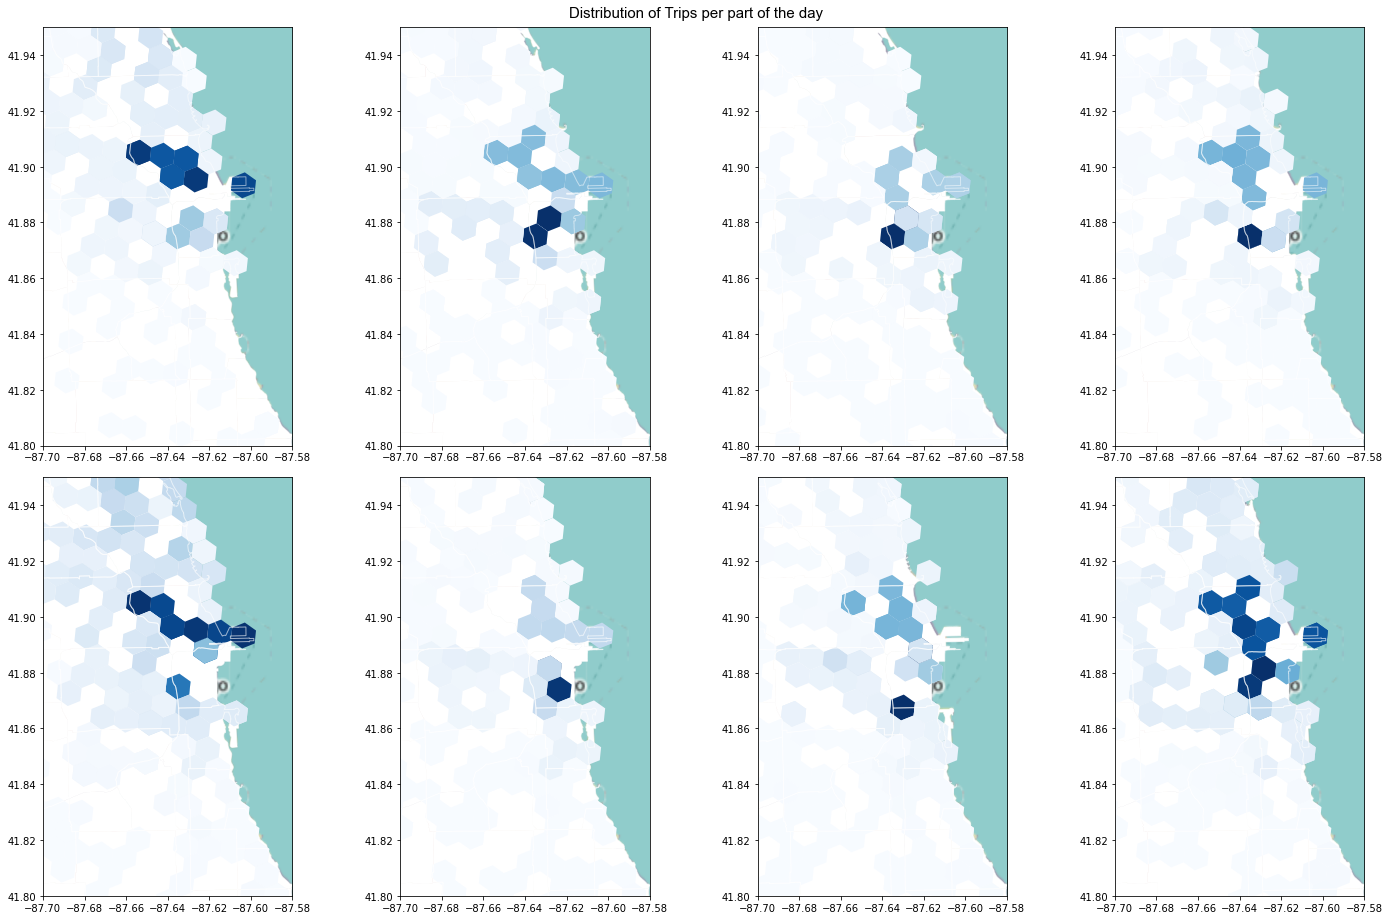

In [91]:
fig,axes = create_subplot_fig(title = "Distribution of Trips per part of the day",figsize=(20,13),x=4,y=2,names=["0-5h","6-11h","12-17h","18-23h"])
for i in range(0,4):
    chicago_com_areas.plot(ax=axes[i],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_pu[df_geo_pu["slice"]==i+1],geometry="geometry").plot(ax=axes[i],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_com_areas.plot(ax=axes[i],color="none",edgecolor="white",alpha=0.5)
    
    chicago_com_areas.plot(ax=axes[i+4],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_do[df_geo_do["slice"]==i+1],geometry="geometry").plot(ax=axes[i+4],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i+4],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_com_areas.plot(ax=axes[i+4],color="none",edgecolor="white",alpha=0.6)
    
    
    axes[i].set_xlim(-87.7,-87.58)
    axes[i].set_ylim(41.8,41.95)
    
    axes[i+4].set_xlim(-87.7,-87.58)
    axes[i+4].set_ylim(41.8,41.95)

# BACKUP

In [4]:
df_raw = pd.read_parquet("../data/df_sample_21_06_2021.parquet")

NameError: name 'pd' is not defined

In [5]:
df_raw[df_raw["Pickup Centroid Location"].isnull() & ~df_raw["Dropoff Centroid  Location"].isnull()]

NameError: name 'df_raw' is not defined

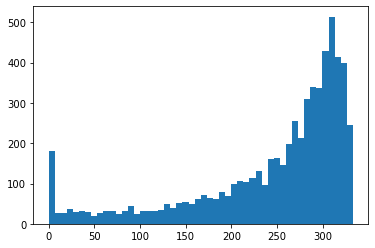

In [15]:
taxi_id_anal= df.groupby("Taxi ID").agg(min_date=("PU_DATE","min"),
                                         max_date=("PU_DATE","max"),
                                         count=("PU_DATE","count"))
taxi_id_anal["length"]=pd.to_timedelta(taxi_id_anal["max_date"]-taxi_id_anal["min_date"]).dt.days
_=plt.hist(taxi_id_anal.length,bins=50)

In [38]:
chicago_fence = gpd.read_file("../data/chicago.geojson")
chicago_boundary_pol = chicago_fence.geometry[0][1]
poly_geojson = gpd.GeoSeries([chicago_boundary_pol]).__geo_interface__
# Parse out geometry key from GeoJSON dictionary
poly_geojson = poly_geojson['features'][0]['geometry'] 

# Create an empty dataframe to write data into
h3_df = pd.DataFrame([],columns=['h3_id','h3_geo_boundary','h3_centroid'])

# Fill the dictionary with H3 Hexagons
h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

for h3_hex in h3_hexes:
    h3_geo_boundary = shapely.geometry.Polygon(
        h3.h3_to_geo_boundary(h3_hex,geo_json=True))
    h3_centroid = h3.h3_to_geo(h3_hex)
    h3_df.loc[len(h3_df)]=[
        h3_hex,
        h3_geo_boundary,
        h3_centroid
        ]
h3_gdf = gpd.GeoDataFrame(h3_df,geometry="h3_geo_boundary")

h3_gdf.head(2)

,h3_id,h3_geo_boundary,h3_centroid
0,892664c162fffff,"POLYGON ((-87.65670 41.93923, -87.65852 41.938...","(41.93748911302492, -87.65611510480193)"
1,892664cad43ffff,"POLYGON ((-87.66797 41.89380, -87.66979 41.892...","(41.89206306038807, -87.66738380233109)"


### Group to H3 Slices

In [17]:
def group_slice(df,hour_feature_name,feature_name,slices,aggs,h3=False):
    df_grouped = df.copy()
    divider = 24/slices
    df_grouped["hour_slice"] = np.floor(df_grouped[hour_feature_name] / divider).astype(int)
    df_grouped = df_grouped.groupby(["hour_slice",feature_name]).agg(aggs)
    df_grouped[feature_name] = df_grouped.index.get_level_values(1)
    df_grouped["hour_slice"] = df_grouped.index.get_level_values(0)
    if h3:
        df_grouped["geometry"] = df_grouped.apply(lambda x: hex_to_geoboundary(x[feature_name]),axis=1)
        df_grouped = gpd.GeoDataFrame(df_grouped, geometry='geometry')
        
    return df_grouped

In [18]:
gdf_sliced_pu = group_slice(df,"PU_HOUR","PU_H3",4,{"Trip ID":"count","Trip Seconds":"mean"},h3=True)
gdf_sliced_pu = gdf_sliced_pu.rename(columns={"Trip ID":"count","PU_H3":"H3"})
gdf_sliced_do = group_slice(df,"DO_HOUR","DO_H3",4,{"Trip ID":"count","Trip Seconds":"mean"},h3=True)
gdf_sliced_do = gdf_sliced_do.rename(columns={"Trip ID":"count","DO_H3":"H3"})
gdf_sliced_pu.sample(10)

count  Trip Seconds               H3  hour_slice  \
hour_slice PU_H3                                                               
1          872664d8dffffff      7   1312.142857  872664d8dffffff           1   
4          872664521ffffff     43   1270.860465  872664521ffffff           4   
1          872664cd3ffffff      2   1089.500000  872664cd3ffffff           1   
3          872664c1affffff   8089    709.290023  872664c1affffff           3   
2          872664521ffffff    466   1972.433476  872664521ffffff           2   
3          872664c10ffffff    280    735.910714  872664c10ffffff           3   
1          872664cf5ffffff    119   1046.731092  872664cf5ffffff           1   
0          872759369ffffff      9    656.555556  872759369ffffff           0   
           872664cf2ffffff      2    688.000000  872664cf2ffffff           0   
3          872664caaffffff      5    799.600000  872664caaffffff           3   

                                                                     geometry  
hour_slice PU_H3                                                               
1          872664d8dffffff  POLYGON ((-87.64646 42.00095, -87.65922 41.992...  
4          872664521ffffff  POLYGON ((-87.76204 41.79236, -87.77471 41.784...  
1          872664cd3ffffff  POLYGON ((-87.71166 41.78075, -87.72434 41.772...  
3          872664c1affffff  POLYGON ((-87.63912 41.88714, -87.65185 41.878...  
2          872664521ffffff  POLYGON ((-87.76204 41.79236, -87.77471 41.784...  
3          872664c10ffffff  POLYGON ((-87.64279 41.94402, -87.65553 41.935...  
1          872664cf5ffffff  POLYGON ((-87.62684 41.85069, -87.63956 41.842...  
0          872759369ffffff  POLYGON ((-87.81550 41.99494, -87.82822 41.986...  
           872664cf2ffffff  POLYGON ((-87.68589 41.84194, -87.69859 41.833...  
3          872664caaffffff  POLYGON ((-87.71916 41.89440, -87.73187 41.886...

### Plot Sliced Heatmap

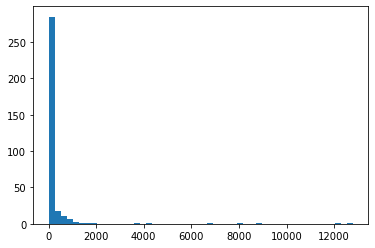

In [191]:
_=plt.hist(gdf_sliced_pu[gdf_sliced_pu["count"]<10000000000]["count"],bins=50)

In [21]:
def plot_chicago_heatmap(df,ax,h3_column,feature_column,h3_gdf,filter_min=0,filter_max=100000000000,cmap="plasma",xlim=False,ylim=False):
    data = df[[h3_column,feature_column]]
    data = pd.merge(h3_gdf,data,how="left",left_on="h3_id",right_on=h3_column)
    data[feature_column] = data[feature_column].fillna(0)
    data_outside = data[(data[feature_column]<=filter_min) | (data[feature_column]>=filter_max)]
    data_inside = data[(data[feature_column]>filter_min) & (data[feature_column]<filter_max)]
    
    
    chicago_fence.plot(ax=ax,edgecolor="white",color="none")
    data_outside.plot(ax=ax,color="grey",alpha=0.5,edgecolor="none")
    plot = data_inside.plot(ax=ax,column=feature_column,cmap=cmap)
    ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    return plot

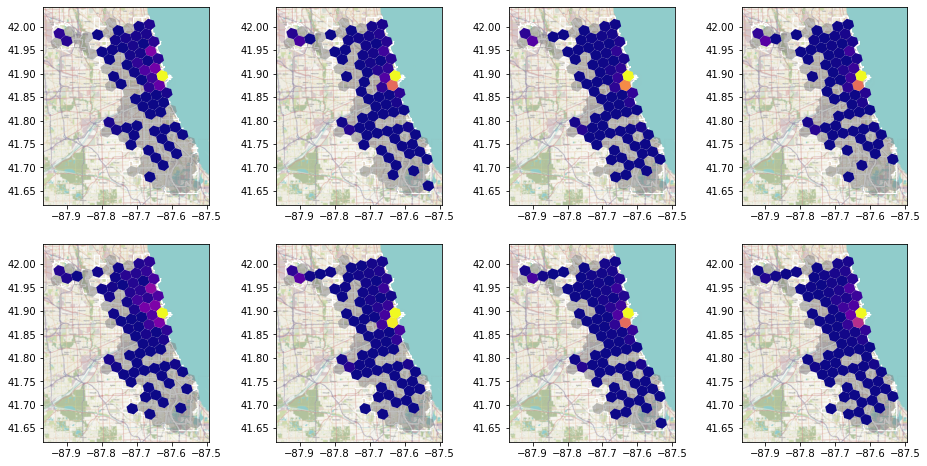

In [22]:
fig,axes = plt.subplots(2,4,figsize = (16,8))

i = 0
for ax in axes[0]:
    plot_df = gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,filter_min=0,filter_max=20000)#xlim=(-87.75,-87.6),ylim=(41.85,41.975))
    i=i+1
    
i = 0
for ax in axes[1]:
    plot_df = gdf_sliced_do[gdf_sliced_do["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,filter_min=0,filter_max=20000)#xlim=(-87.75,-87.6),ylim=(41.85,41.975))
    i=i+1

<AxesSubplot:>

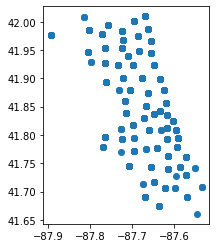

In [243]:
kepler_gdf.plot()

In [248]:
from keplergl import KeplerGl

kepler_df = df_geo.copy()
kepler_df = kepler_df[~kepler_df["Pickup Community Area"].isnull() & ~kepler_df["Dropoff Community Area"].isnull()]
kepler_df["Pickup Community Area"] = kepler_df["Pickup Community Area"].astype(int)
kepler_df["Dropoff Community Area"] = kepler_df["Dropoff Community Area"].astype(int)
kepler_df = kepler_df.groupby(["Pickup Community Area","Dropoff Community Area","PU_HOUR"]).agg(PU=("Pickup Community Area","min"),
                                                                                               DO =("Pickup Community Area","min"),
                                                                                               HOUR =  ("PU_HOUR","mean"),
                                                                                               mph = ("mph","median"))

com_area_geo = chicago_fence[["area_num_1","centroid"]]

kepler_df=pd.merge(kepler_df,com_area_geo,how="left",left_on="PU",right_on="area_num_1")
kepler_df = kepler_df.rename(columns={"centroid":"PU_centroid"})
kepler_df = kepler_df.drop(columns="area_num_1")

kepler_df=pd.merge(kepler_df,com_area_geo,how="left",left_on="DO",right_on="area_num_1")
kepler_df = kepler_df.rename(columns={"centroid":"DO_centroid"})
kepler_df = kepler_df.drop(columns="area_num_1")

kepler_df
kepler_gdf = gpd.GeoDataFrame(kepler_df,geometry="DO_centroid")
kepler_gdf = gpd.GeoDataFrame(kepler_gdf,geometry="PU_centroid")

keplermap = KeplerGl(height=400)
keplermap.add_data(data=kepler_df, name="points")
keplermap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


ValueError: Can't clean for JSON: <shapely.geometry.point.Point object at 0x000001740D811310>

In [138]:
df_grouped_pu = df.groupby("PU_H3").agg(avgduration=("Trip Seconds","mean"),
                                        avgdistance=("Trip Miles","mean"),
                                        avgpay=("Trip Total","mean"),
                                        count=("Trip Total","count"),
                                        revenue=("Trip Total","sum"),
                                        H3=("PU_H3","min"))

df_grouped_pu["revenue_per_ride"] = df_grouped_pu["revenue"]/df_grouped_pu["count"]

In [139]:
df_grouped_pu

,avgduration,avgdistance,avgpay,count,revenue,H3,revenue_per_ride
PU_H3,,,,,,,
872664191ffffff,1552.454545,10.067273,28.640909,11,315.05,872664191ffffff,28.640909
872664196ffffff,1340.547619,5.676190,23.305238,84,1957.64,872664196ffffff,23.305238
8726641b2ffffff,2216.823529,14.200588,42.264706,17,718.50,8726641b2ffffff,42.264706
872664520ffffff,1687.042640,10.955341,41.232397,6121,252383.50,872664520ffffff,41.232397
872664521ffffff,1880.289754,11.600942,44.441488,14571,647556.92,872664521ffffff,44.441488
...,...,...,...,...,...,...,...
87275934cffffff,1240.426230,7.827541,28.811475,61,1757.50,87275934cffffff,28.811475
87275934effffff,2275.362801,14.812195,53.211072,50937,2710412.38,87275934effffff,53.211072
872759369ffffff,1096.757835,5.910342,22.580299,702,15851.37,872759369ffffff,22.580299


Text(0.5, 1.0, 'Duration')

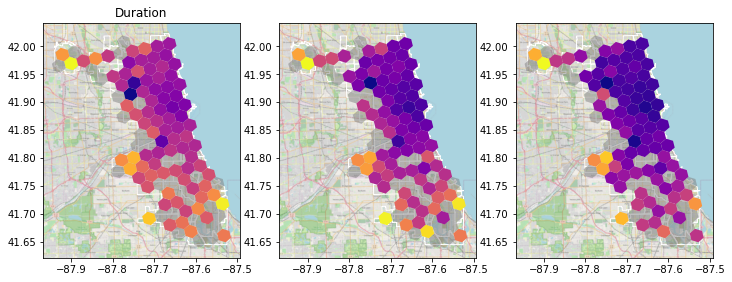

In [140]:
fig,axes = plt.subplots(1,3,figsize=(12,8))
duration_plot = plot_chicago_heatmap(df_grouped_pu,axes[0],"H3","avgduration",h3_gdf)
distance_plot = plot_chicago_heatmap(df_grouped_pu,axes[1],"H3","avgdistance",h3_gdf)
revenue_plot = plot_chicago_heatmap(df_grouped_pu,axes[2],"H3","revenue_per_ride",h3_gdf)

axes[0].set_title("Duration")

## Write results in parquet file 